### Import Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import warnings
warnings.filterwarnings('ignore')
from forex_python.converter import CurrencyRates
import re
from scipy.stats import skew, kurtosis
from scipy.stats import chi2_contingency
from scipy.stats import ks_2samp
import scipy.stats
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from scipy.stats import kruskal, mannwhitneyu

### Load Data

In [3]:
df_2018 = pd.read_csv('startup_funding2018.csv')
df_2019 = pd.read_csv('startup_funding2019.csv')
df_2020 = pd.read_csv('startup_funding2020.csv')
df_2021 = pd.read_csv('startup_funding2021.csv')

### See Column names of 2018-2021 Dataframes

In [4]:
df_2018.head(0)

,Company Name,Industry,Round/Series,Amount,Location,About Company


In [5]:
df_2019.head(0)

,Company/Brand,Founded,HeadQuarter,Sector,What it does,Founders,Investor,Amount($),Stage


In [6]:
df_2020.head(0)

,Unnamed: 0,Company_Brand,Founded,HeadQuarter,Sector,What_it_does,Founders,Investor,Amount,Stage,column10


In [7]:
df_2021.head(0)

,Unnamed: 0,Company_Brand,Founded,HeadQuarter,Sector,What_it_does,Founders,Investor,Amount,Stage


### Standardize Column Names, Drop Unnamed:0, Column 10, Add Year Column and Concatenate 

In [8]:
df_2018 = df_2018.rename(columns={'Company Name': 'Company Brand', 'Industry': 'Sector', 'Round/Series': 'Stage', 'About Company': 'What it does?'})
df_2019 = df_2019.rename(columns={'Company/Brand': 'Company Brand', 'HeadQuarter': 'Location', 'What it does': 'What it does?', 'Amount($)':'Amount'})
df_2020 = df_2020.rename(columns={'Company_Brand': 'Company Brand', 'HeadQuarter': 'Location', 'What_it_does': 'What it does?'})
df_2021 = df_2021.rename(columns={'Company_Brand': 'Company Brand', 'HeadQuarter': 'Location', 'What_it_does': 'What it does?'})
df_2020 = df_2020.drop(['Unnamed: 0', 'column10'], axis=1) # Drop 'Unnamed: 0' und 'column 10'
df_2021 = df_2021.drop(['Unnamed: 0'], axis=1)
df_2018['Year'] = 2018 # Add a 'Year' column to each DataFrame
df_2019['Year'] = 2019
df_2020['Year'] = 2020
df_2021['Year'] = 2021
df_concat = pd.concat([df_2018, df_2019, df_2020, df_2021], ignore_index=True) # Concatenate
df_concat.head(2)

,Company Brand,Sector,Stage,Amount,Location,What it does?,Year,Founded,Founders,Investor
0,TheCollegeFever,"Brand Marketing, Event Promotion, Marketing, S...",Seed,250000,"Bangalore, Karnataka, India","TheCollegeFever is a hub for fun, fiesta and f...",2018,NaN,NaN,NaN
1,Happy Cow Dairy,"Agriculture, Farming",Seed,"₹40,000,000","Mumbai, Maharashtra, India",A startup which aggregates milk from dairy far...,2018,NaN,NaN,NaN


### Check and Handle Duplicates

In [9]:
df_concat.duplicated().sum()

23

In [10]:
df_concat.drop_duplicates().info()

<class 'pandas.core.frame.DataFrame'>
Index: 2856 entries, 0 to 2878
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Company Brand  2856 non-null   object 
 1   Sector         2838 non-null   object 
 2   Stage          1927 non-null   object 
 3   Amount         2598 non-null   object 
 4   Location       2742 non-null   object 
 5   What it does?  2856 non-null   object 
 6   Year           2856 non-null   int64  
 7   Founded        2088 non-null   float64
 8   Founders       2312 non-null   object 
 9   Investor       2232 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 245.4+ KB


### Check Missing Values

In [11]:
df_concat.isnull().sum()

Company Brand      0
Sector            18
Stage            938
Amount           259
Location         114
What it does?      0
Year               0
Founded          769
Founders         545
Investor         626
dtype: int64

### Fill Object Columns with 'Uknown'

In [12]:
columns_to_fill = ['Sector', 'Stage', 'Location', 'What it does?', 'Founders', 'Investor']# List of columns to fill 
df_concat[columns_to_fill] = df_concat[columns_to_fill].fillna('Unknown') #Fill missing values with "Unknown"
df_concat.head(2)

,Company Brand,Sector,Stage,Amount,Location,What it does?,Year,Founded,Founders,Investor
0,TheCollegeFever,"Brand Marketing, Event Promotion, Marketing, S...",Seed,250000,"Bangalore, Karnataka, India","TheCollegeFever is a hub for fun, fiesta and f...",2018,NaN,Unknown,Unknown
1,Happy Cow Dairy,"Agriculture, Farming",Seed,"₹40,000,000","Mumbai, Maharashtra, India",A startup which aggregates milk from dairy far...,2018,NaN,Unknown,Unknown


### Check and Handle Simmilar Category but different in Spelling of Sector Column

In [13]:
sorted_values = sorted(df_concat['Sector'].unique())
print(sorted_values[:50])

['3D Printing, Manufacturing, Product Design', 'AI', 'AI & Data science', 'AI & Debt', 'AI & Deep learning', 'AI & Media', 'AI & Tech', 'AI Chatbot', 'AI Company', 'AI Platform', 'AI Robotics', 'AI Startup', 'AI company', 'AI health', 'AI platform', 'AI startup', 'API platform', 'AR platform', 'AR startup', 'AR/VR', 'AR/VR startup', 'Accomodation', 'Accounting, Apps, FinTech', 'Accounting, Banking, Finance', 'Accounting, Business Information Systems, Business Travel, Finance, SaaS', 'Ad-tech', 'Advertisement', 'Advertising, Artificial Intelligence, Digital Media, iOS, Location Based Services, News, Video, Video on Demand, Video Streaming', 'Advertising, Consulting, Digital Marketing', 'Advertising, Human Resources, Marketing', 'Advertising, Internet, Marketing', 'Advisory firm', 'Aeorspace', 'Aero company', 'Aerospace', 'AgTech, B2B, Supply Chain Management', 'Agri tech', 'AgriTech', 'Agriculture', 'Agriculture, AgTech, Artificial Intelligence, Internet of Things, Machine Learning', 'A

In [14]:
# Define replacements for sectors
replacements = {
    'Aeorspace: Aerospace',
    'Aero Company: Aerospace',
    'Agritech: Agri Tech',
    'Agritech Startup: Agri Tech',
    'Agritech/Commerce: Agri Tech',
    'Ai: Artificial Intelligence',
    'Automation: Automation Tech',
    'Automobile &Technology: Automobile Technology',
    'Automobiles: Automobile Technology',
    'Automotive: Automobile Technology',
    'Automotive Company: Automobile Technology',
    'Automotive Startup: Automobile Technology',
    'Automotive Tech: Automobile Technology',
    'Biotech: Biotechnology',
    'Biotechnology Company: Biotechnology',
    'Blockchain: Blockchain Startup',
    'Construction Tech: Construction',
    'Consulting: Consultancy',
    'Deep Tech Ai: Deep Tech',
    'Deeptech: Deep Tech',
    'Deeptech Startup: Deep Tech',
    'Ecommerce: E-Commerce',
    'Edtech Startup: Edtech',
    'Edttech: Edtech',
    'Eye Wear: Eyewear',
    'Eyeglasses: Eyewear',
    'Eyewear, Internet: Eyewear',
    'Foodtech: Food Tech',
    'Foodtech & Logistics: Food Tech',
    'Gaming: Games',
    'Gaming Startup: Games',
    'Healtcare: Healthcare',
    'Health: Healthcare',
    'Health Care: Healthcare',
    'Healthtech: Health Tech',
    'Heathcare: Healthcare',
    'Heathtech: Health Tech',
    'Hr Tech Startup: Hr Tech',
    'Hrtech: Hr Tech',
    'Hr: Human Resources',
    'Insurance Technology: Insurance Tech',
    'Insuretech: Insurance Tech',
    'Insurtech: Insurance Tech',
    'It: IT Startup',
    'It Company: IT Startup',
    'It Startup: IT Startup',
    'Jewellery Startup: Jewelry',
    'Legaltech: Legal Tech'}
df_concat['Sector'] = df_concat['Sector'].replace({ # Replace values in the 'Sector' column based on the dictionary
    value.split(': ')[0]: value.split(': ')[1] if len(value.split(': ')) > 1 else value
    for value in replacements})
sorted_values = sorted(df_concat['Sector'].unique()) # Sort and print the unique values in the 'Sector' column
print(sorted_values[:50])

['3D Printing, Manufacturing, Product Design', 'AI', 'AI & Data science', 'AI & Debt', 'AI & Deep learning', 'AI & Media', 'AI & Tech', 'AI Chatbot', 'AI Company', 'AI Platform', 'AI Robotics', 'AI Startup', 'AI company', 'AI health', 'AI platform', 'AI startup', 'API platform', 'AR platform', 'AR startup', 'AR/VR', 'AR/VR startup', 'Accomodation', 'Accounting, Apps, FinTech', 'Accounting, Banking, Finance', 'Accounting, Business Information Systems, Business Travel, Finance, SaaS', 'Ad-tech', 'Advertisement', 'Advertising, Artificial Intelligence, Digital Media, iOS, Location Based Services, News, Video, Video on Demand, Video Streaming', 'Advertising, Consulting, Digital Marketing', 'Advertising, Human Resources, Marketing', 'Advertising, Internet, Marketing', 'Advisory firm', 'Aero company', 'Aerospace', 'AgTech, B2B, Supply Chain Management', 'Agri Tech', 'Agri tech', 'AgriTech', 'Agriculture', 'Agriculture, AgTech, Artificial Intelligence, Internet of Things, Machine Learning', 'A

### Check and Handle Simmilar Category but different in Spelling of Stage Column

In [15]:
sorted_values = sorted(df_concat['Stage'].unique())
print(sorted_values)

['$1000000', '$1200000', '$300000', '$6000000', 'Angel', 'Angel Round', 'Bridge', 'Bridge Round', 'Corporate Round', 'Debt', 'Debt Financing', 'Early seed', 'Edge', 'Fresh funding', 'Funding Round', 'Grant', 'Mid series', 'Non-equity Assistance', 'PE', 'Post series A', 'Post-IPO Debt', 'Post-IPO Equity', 'Pre Series A', 'Pre seed Round', 'Pre seed round', 'Pre series A', 'Pre series A1', 'Pre series B', 'Pre series C', 'Pre- series A', 'Pre-Seed', 'Pre-Series B', 'Pre-seed', 'Pre-seed Round', 'Pre-series', 'Pre-series A', 'Pre-series A1', 'Pre-series B', 'Pre-series C', 'Private Equity', 'Secondary Market', 'Seed', 'Seed A', 'Seed Funding', 'Seed Investment', 'Seed Round', 'Seed Round & Series A', 'Seed fund', 'Seed funding', 'Seed round', 'Seed+', 'Seies A', 'Series A', 'Series A+', 'Series A-1', 'Series A2', 'Series B', 'Series B+', 'Series B2', 'Series B3', 'Series C', 'Series C, D', 'Series D', 'Series D1', 'Series E', 'Series E2', 'Series F', 'Series F1', 'Series F2', 'Series G', 

In [16]:
stage_replacements = {
    'Angel': 'Angel Round',
    'Bridge': 'Bridge Round',
    'Pre Seed Round': 'Pre-Seed Round',
    'Pre Series A': 'Pre-Series A',
    'Pre Series A1': 'Pre-Series A1',
    'Pre Series B': 'Pre-Series B',
    'Pre Series C': 'Pre-Series C',
    'Pre-Series A': 'Pre-Series A',
    'Seed Fund': 'Seed Funding',
    'Seies A': 'Series A',
    'Undisclosed': 'Unknown',
    'Venture - Series Unknown': 'Unknown',
    '$1000000': 'Unknown',
    '$1200000': 'Unknown',
    '$300000': 'Unknown',
    '$6000000': 'Unknown'
}
link_to_remove = 'https://Docs.Google.Com/Spreadsheets/D/1X9Zineaz6Aunchihnmi8U6Ks7Kntr3Byy_Ybgfqaoua/Edit#Gid=1861303593'
df_concat = df_concat[~df_concat['Stage'].str.contains(link_to_remove, case=False, na=False)] # Remove rows containing the specified link in the 'Stage' column
df_concat['Stage'] = df_concat['Stage'].replace(stage_replacements) # Replace values in the 'Stage' column based on the dictionary
sorted_values = sorted(df_concat['Stage'].unique())
print(sorted_values)

['Angel Round', 'Bridge Round', 'Corporate Round', 'Debt', 'Debt Financing', 'Early seed', 'Edge', 'Fresh funding', 'Funding Round', 'Grant', 'Mid series', 'Non-equity Assistance', 'PE', 'Post series A', 'Post-IPO Debt', 'Post-IPO Equity', 'Pre seed Round', 'Pre seed round', 'Pre series A', 'Pre series A1', 'Pre series B', 'Pre series C', 'Pre- series A', 'Pre-Seed', 'Pre-Series A', 'Pre-Series B', 'Pre-seed', 'Pre-seed Round', 'Pre-series', 'Pre-series A', 'Pre-series A1', 'Pre-series B', 'Pre-series C', 'Private Equity', 'Secondary Market', 'Seed', 'Seed A', 'Seed Funding', 'Seed Investment', 'Seed Round', 'Seed Round & Series A', 'Seed fund', 'Seed funding', 'Seed round', 'Seed+', 'Series A', 'Series A+', 'Series A-1', 'Series A2', 'Series B', 'Series B+', 'Series B2', 'Series B3', 'Series C', 'Series C, D', 'Series D', 'Series D1', 'Series E', 'Series E2', 'Series F', 'Series F1', 'Series F2', 'Series G', 'Series H', 'Series I', 'Unknown']


### Clean the Amount Column

In [17]:
def convert_to_usd(row):
    try:
        amount = row['Amount']
        year = row['Year']        
        if isinstance(amount, (int, float)):  # Check if amount is already a number
            return float(amount)
        if '₹' in str(amount): # If the amount contains '₹', remove it and convert to float
            amount = str(amount).replace('₹', '').replace(',', '')
            exchange_rate = {2018: 68.5, 2019: 70.4,2020: 74.3, 2021: 73.9}
            return float(amount) / exchange_rate.get(year, 1.0) # Convert to float and divide by the corresponding exchange rate
        elif '$' in str(amount):  # If the amount contains '$', remove it and convert to float
            amount = str(amount).replace('$', '').replace(',', '')
            return float(amount)
        elif ',' in str(amount):  # If the amount is just a number with commas, remove commas and convert to float
            amount = str(amount).replace(',', '')
            return float(amount)
        elif pd.to_numeric(amount, errors='coerce') is np.nan or pd.isna(pd.to_numeric(amount, errors='coerce')):
            return np.nan  # If the amount is '—' or any other non-numeric value, return NaN
        else:  # If the amount is already in dollars, return it as is
            return float(amount)    
    except ValueError:
        return np.nan
df_concat['Amount'] = df_concat.apply(convert_to_usd, axis=1)
df_concat.isnull().sum()

Company Brand      0
Sector             0
Stage              0
Amount           567
Location           0
What it does?      0
Year               0
Founded          768
Founders           0
Investor           0
dtype: int64

### Skewness and Kurtosis to check for Outliers of the Amount Column

In [18]:
amount_data = df_concat['Amount'].dropna()  # Drop NaN values if any
skewness = skew(amount_data)
kurt = kurtosis(amount_data)
print(f'Skewness: {skewness}')
print(f'Kurtosis: {kurt}')

Skewness: 39.31465661441652
Kurtosis: 1624.3685037799917


The skewness value of 39.32 indicates a highly skewed 'Amount' column, suggesting non-normality. The kurtosis value of 1625.07 is exceptionally high, implying heavy tails and a peaked distribution. This signals susceptibility to outliers. Linear interpolation may not be suitable for such data. Instead, consider techniques like median imputation, logarithmic or Box-Cox transformations, training a model, or multiple imputation. A skewness of 39.32 suggests extreme skewness, making median imputation a robust choice for handling missing values. The median is less sensitive to outliers than the mean, preserving distribution integrity in non-normally distributed data.

### Filling Missing Values of Amount with Median

In [19]:
imputer = SimpleImputer(strategy='median')  # You can use other strategies like 'median' or 'most_frequent'
df_concat['Amount'] = imputer.fit_transform(df_concat[['Amount']]) # Apply imputed values

### Formating the Object Column Values to address issues such as Fintech and FinTech

In [20]:
# List of columns to format
columns_to_format = ['Sector', 'Stage', 'Location', 'What it does?', 'Founders', 'Investor']
for column in columns_to_format: # Apply the formatting to each specified column
    df_concat[column] = df_concat[column].str.title()
df_concat.head(2)

,Company Brand,Sector,Stage,Amount,Location,What it does?,Year,Founded,Founders,Investor
0,TheCollegeFever,"Brand Marketing, Event Promotion, Marketing, S...",Seed,250000.000000,"Bangalore, Karnataka, India","Thecollegefever Is A Hub For Fun, Fiesta And F...",2018,NaN,Unknown,Unknown
1,Happy Cow Dairy,"Agriculture, Farming",Seed,583941.605839,"Mumbai, Maharashtra, India",A Startup Which Aggregates Milk From Dairy Far...,2018,NaN,Unknown,Unknown


### Check and Handle Simmilar Category but different in Spelling of Location Column

In [21]:
sorted_values = sorted(df_concat['Location'].unique())
print(sorted_values[:50])

['Ahmadabad', 'Ahmedabad', 'Ahmedabad, Gujarat, India', 'Alleppey, Kerala, India', 'Alwar, Rajasthan, India', 'Ambernath', 'Anand, Gujarat, India', 'Andheri', 'Andheri, Maharashtra, India', 'Azadpur, Delhi, India', 'Bangaldesh', 'Bangalore', 'Bangalore City, Karnataka, India', 'Bangalore, Karnataka, India', 'Bangkok', 'Banglore', 'Beijing', 'Belgaum', 'Belgaum, Karnataka, India', 'Bengaluru', 'Bengaluru, Karnataka, India', 'Berlin', 'Bhilwara', 'Bhopal', 'Bhopal, Madhya Pradesh, India', 'Bhubaneswar', 'Bihar', 'California', 'Chandigarh', 'Chandigarh, Chandigarh, India', 'Chennai', 'Chennai, Tamil Nadu, India', 'Cochin', 'Cochin, Kerala, India', 'Coimbatore', 'Coimbatore, Tamil Nadu, India', 'Computer Games', 'Dehradun', 'Delhi', 'Delhi, Delhi, India', 'Dhingsara, Haryana', 'Ernakulam, Kerala, India', 'Faridabad', 'Faridabad, Haryana', 'Faridabad, Haryana, India', 'Food & Beverages', 'France', 'Frisco, Texas, United States', 'Gandhinagar', 'Ghaziabad']


In [22]:
# Define corrections for locations
corrections = {
    'Ahmadabad': 'Ahmedabad',
    'Ahmedabad, Gujarat, India': 'Ahmedabad',
    'Andheri, Maharashtra, India': 'Andheri',
    'Bangalore City, Karnataka, India': 'Bangalore',
    'Bangalore, Karnataka, India': 'Bangalore',
    'Banglore': 'Bangalore',
    'Bengaluru, Karnataka, India': 'Bengaluru',
    'Bhopal, Madhya Pradesh, India': 'Bhopal',
    'Chandigarh, Chandigarh, India': 'Chandigarh',
    'Chennai, Tamil Nadu, India': 'Chennai',
    'Cochin, Kerala, India': 'Cochin',
    'Coimbatore, Tamil Nadu, India': 'Coimbatore',
    'Computer GamesP Coimbatore': 'Coimbatore',
    'Delhi, Delhi, India': 'Delhi',
    'Faridabad, Haryana': 'Faridabad',
    'Faridabad, Haryana, India': 'Faridabad',
    'Gurgaon, Haryana, India': 'Gurgaon',
    'Gurugram#Ref!': 'Gurugram',
    'Hyderabad, Andhra Pradesh, India': 'Hyderabad',
    'Hyderebad': 'Hyderabad',
    'Indore, Madhya Pradesh, India': 'Indore',
    'Jaipur, Rajastan': 'Jaipur',
    'Jaipur, Rajasthan, India': 'Jaipur',
    'Jodhpur, Rajasthan, India': 'Jodhpur',
    'Kannur, Kerala, India': 'Kanpur',
    'Kanpur, Uttar Pradesh, India': 'Kanpur',
    'Kochi, Kerala, India': 'Kochi',
    'Kolkata, West Bengal, India': 'Kolkata',
    'London, England, United Kingdom': 'London',
    'Lucknow, Uttar Pradesh, India': 'Lucknow',
    'Mohali, Punjab, India': 'Mohali',
    'Mumbai, Maharashtra, India': 'Mumbai',
    'New Delhi, Delhi, India': 'New Delhi',
    'New York, United States': 'New York',
    'Newcastle Upon Tyne, Newcastle Upon Tyne, United Kingdom': 'Newcastle Upon Tyne, United Kingdom',
    'Noida, Uttar Pradesh, India': 'Noida',
    'Powai, Assam, India': 'Powai',
    'Pune, Maharashtra, India': 'Pune',
    'Rajasthan': 'Rajasthan',
    'Samastipur, Bihar': 'Samastipur',
    'San Franciscao': 'San Francisco',
    'San Francisco': 'San Francisco',
    'San Francisco Bay Area, Silicon Valley, West Coast': 'San Francisco',
    'San Francisco Bay Area, West Coast, Western Us': 'San Francisco',
    'San Francisco, California, United States': 'San Francisco',
    'San Francisco, United States': 'San Francisco',
    'Santra': 'Satara',
    'Sydney, New South Wales, Australia': 'Sydney',
    'Telugana': 'Telangana',
    'Thane, Maharashtra, India': 'Thane',
    'Trivandrum, Kerala, India': 'Trivandrum',
}
df_concat['Location'] = df_concat['Location'].replace(corrections) # Replace values in the 'Location' column based on the dictionary
sorted_values = sorted(df_concat['Location'].unique()) # Sort and print the unique values in the 'Location' column
print(sorted_values[:50])

['Ahmedabad', 'Alleppey, Kerala, India', 'Alwar, Rajasthan, India', 'Ambernath', 'Anand, Gujarat, India', 'Andheri', 'Azadpur, Delhi, India', 'Bangaldesh', 'Bangalore', 'Bangkok', 'Beijing', 'Belgaum', 'Belgaum, Karnataka, India', 'Bengaluru', 'Berlin', 'Bhilwara', 'Bhopal', 'Bhubaneswar', 'Bihar', 'California', 'Chandigarh', 'Chennai', 'Cochin', 'Coimbatore', 'Computer Games', 'Dehradun', 'Delhi', 'Dhingsara, Haryana', 'Ernakulam, Kerala, India', 'Faridabad', 'Food & Beverages', 'France', 'Frisco, Texas, United States', 'Gandhinagar', 'Ghaziabad', 'Ghaziabad, Uttar Pradesh, India', 'Goa', 'Guindy, Tamil Nadu, India', 'Gujarat', 'Guntur, Andhra Pradesh, India', 'Gurgaon', 'Gurugram', 'Gurugram\t#Ref!', 'Guwahati', 'Haryana', 'Haryana, Haryana, India', 'Hubli, Karnataka, India', 'Hyderabad', 'India, Asia', 'Indore']


In [23]:
founded_data = df_concat['Founded'].dropna()  # Drop NaN values if any
skewness = skew(founded_data)
kurt = kurtosis(founded_data)
print(f'Skewness: {skewness}')
print(f'Kurtosis: {kurt}')

Skewness: -3.6595335039306773
Kurtosis: 26.64835541280489


In [24]:
df_concat['Founded'].unique()

array([  nan, 2014., 2004., 2013., 2010., 2018., 2019., 2017., 2011.,
       2015., 2016., 2012., 2008., 2020., 1998., 2007., 1982., 2009.,
       1995., 2006., 1978., 1999., 1994., 2005., 1973., 2002., 2001.,
       2021., 1993., 1989., 2000., 2003., 1991., 1984., 1963.])

In [25]:
imputer = SimpleImputer(strategy='median')
df_concat['Founded'] = df_concat['Founded'].transform(lambda x: x.fillna(x.median()))
df_concat['Founded'] = df_concat['Founded'].astype(int)
df_concat.isnull().sum()

Company Brand    0
Sector           0
Stage            0
Amount           0
Location         0
What it does?    0
Year             0
Founded          0
Founders         0
Investor         0
dtype: int64

### 1) Is the Funding increasing from year to year?

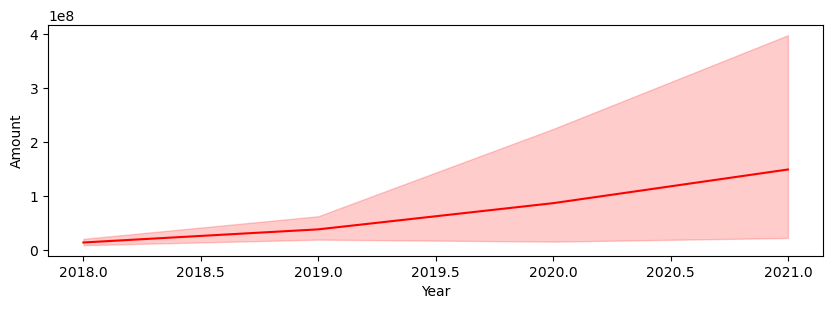

In [26]:
fig, ax = plt.subplots(figsize=(10, 3))
sns.lineplot(data=df_concat, x='Year', y='Amount', color='red', ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Amount')
plt.show()

## 1) What is the distribution of funding across different sectors look like?

### 1.1) What are the top 10 sectors based on amount funded? Which sector received the highest fund?

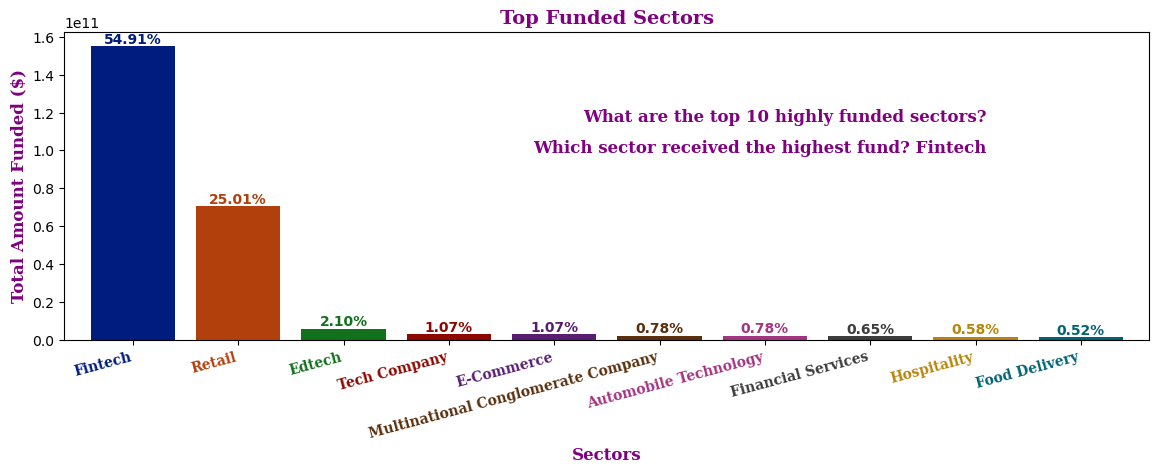

In [27]:
sector_funding = df_concat.groupby('Sector')['Amount'].sum()#Group by'Sector'to get the sum of funding for each sector
sorted_sectors = sector_funding.sort_values(ascending=False) # Sort the sectors by total funding in descending order
top_funded_sectors = sorted_sectors.head(10) # Select the top 15 funded sectors
bar_colors = sns.color_palette('dark', n_colors=len(top_funded_sectors)) # Choose bar colors using the color palette
plt.figure(figsize=(14, 4))
ax = top_funded_sectors.plot(kind='bar', color=bar_colors, width=0.8)
for p, sector, funding, color in zip(ax.patches, top_funded_sectors.index, top_funded_sectors.values, bar_colors):
    percentage = (funding / sector_funding.sum()) * 100
    wrapped_text = '\n'.join(textwrap.wrap(sector, width=12))  # Wrap the text below the bar
    ax.annotate(f'{percentage:.2f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color=color, fontweight='bold',
                xytext=(0, 5), textcoords='offset points')
for label, color in zip(ax.get_xticklabels(), bar_colors): 
    label.set_color(color) # Set the color of the corresponding x-axis label to match the bar color
ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha='right', fontsize=10, fontweight='bold', family='serif')
plt.text(0.85, 0.75, 'What are the top 10 highly funded sectors?', transform=ax.transAxes, # Add text on the graph
         fontsize=12, color='purple', ha='right', va='top', fontweight='bold', family='serif')
plt.text(0.85, 0.65, f'Which sector received the highest fund? {top_funded_sectors.idxmax()}', transform=ax.transAxes,
         fontsize=12, color='purple', ha='right', va='top', fontweight='bold', family='serif') # Add text on the graph
plt.title('Top Funded Sectors', fontsize=14, fontweight='bold', color='purple', family='serif')
plt.xlabel('Sectors', fontsize=12, color='purple', fontweight='bold', family='serif')
plt.ylabel('Total Amount Funded ($)', fontsize=12, color='purple', fontweight='bold', family='serif')
plt.show()

### 1.2) Does Sector affect funding (Amount)?

In [28]:
# Perform the Kruskal-Wallis test to assess if there are significant differences in funding across locations
statistic, p_value = kruskal(*[group['Amount'] for name, group in df_concat.groupby('Sector')])
print(f'Kruskal-Wallis Statistic: {statistic}')
print(f'P-value: {p_value}')
alpha = 0.05 # Interpret the results
if p_value < alpha:
    print()
    print('Yes, Sector affects Funding. The Kruskal-Wallis test rejects the null hypothesis. There are significant differences in funding across sectors. This means sector affects funding')
else:
    print('The Kruskal-Wallis test fails to reject the null hypothesis. There are no significant differences in funding across sectors.')

Kruskal-Wallis Statistic: 942.3679260372584
P-value: 0.0013673758896712664

Yes, Sector affects Funding. The Kruskal-Wallis test rejects the null hypothesis. There are significant differences in funding across sectors. This means sector affects funding


## 2) Does the location of the startup headquarter impact its funding (Amount)?

### 2.1) Which locations of the startups headquarter Receive more funding (Amount)?

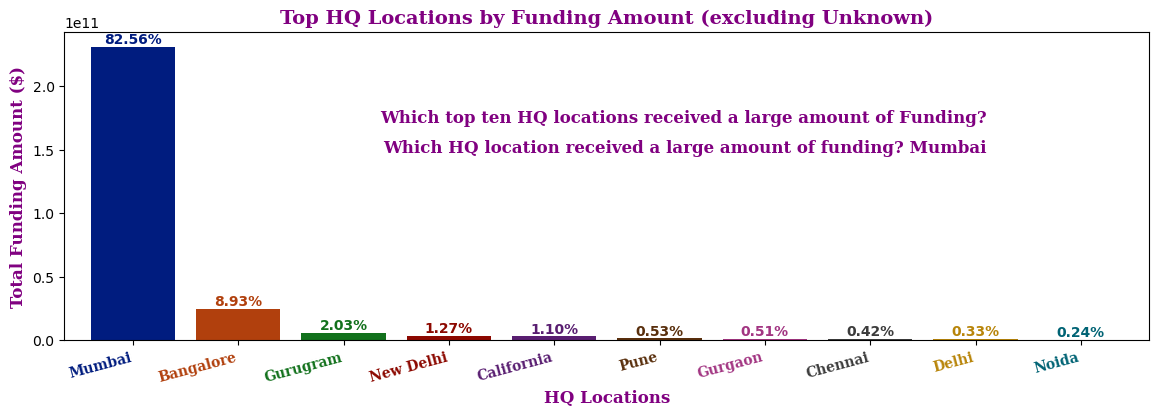

In [29]:
df_filtered = df_concat[df_concat['Location'] != 'Unknown'] # Filter out rows with 'Unknown' in the 'Location' column
location_startup = df_filtered.groupby('Location')['Amount'].sum() # Group by 'Location' and sum the funding amounts
sorted_locations = location_startup.sort_values(ascending=False) # Sort locations by the sum of funding amounts
top_startup_locations = sorted_locations.head(10) # Select the top 10 locations
bar_colors = sns.color_palette('dark', n_colors=len(top_startup_locations)) # Choose bar colors using the color palette
plt.figure(figsize=(14, 4)) # Plot the bar chart
ax = top_startup_locations.plot(kind='bar', color=bar_colors, width=0.8)

for p, location, amount, color in zip(ax.patches, top_startup_locations.index, top_startup_locations.values, bar_colors):
    percentage = (amount / location_startup.sum()) * 100
    wrapped_text = '\n'.join(textwrap.wrap(location, width=12))
    annotation_text = f'{percentage:.2f}%'
    ax.annotate(annotation_text,
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color=color, fontweight='bold',
                xytext=(0, 5), textcoords='offset points')

for label, color in zip(ax.get_xticklabels(), bar_colors):
    label.set_color(color)
ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha='right', fontsize=10, fontweight='bold', family='serif')
plt.text(0.85, 0.75, 'Which top ten HQ locations received a large amount of Funding?', transform=ax.transAxes, # Add text on the graph
         fontsize=12, color='purple', ha='right', va='top', fontweight='bold', family='serif')
plt.text(0.85, 0.65, f'Which HQ location received a large amount of funding? {top_startup_locations.idxmax()}', transform=ax.transAxes,
         fontsize=12, color='purple', ha='right', va='top', fontweight='bold', family='serif')

plt.title('Top HQ Locations by Funding Amount (excluding Unknown)', fontsize=14, fontweight='bold', color='purple', family='serif')
plt.xlabel('HQ Locations', fontsize=12, color='purple', fontweight='bold', family='serif')
plt.ylabel('Total Funding Amount ($)', fontsize=12, color='purple', fontweight='bold', family='serif')
plt.show()

### 2.2) Does locations of the startups headquarter affect funding (Amount)?

In [30]:
# Perform the Kruskal-Wallis test to assess if there are significant differences in funding across locations
statistic, p_value = kruskal(*[group['Amount'] for name, group in df_concat.groupby('Location')])
print(f'Kruskal-Wallis Statistic: {statistic}')
print(f'P-value: {p_value}')
alpha = 0.05 # Interpret the results
print()
if p_value < alpha:
    print('P-value is less than 0.05 meaning the Kruskal-Wallis test rejects the null hypothesis. There are significant differences in funding across HQ locations.')
else:
    print('The Kruskal-Wallis test fails to reject the null hypothesis. There are no significant differences in funding across locations.')

Kruskal-Wallis Statistic: 238.37119415530313
P-value: 5.992780737255604e-09

P-value is less than 0.05 meaning the Kruskal-Wallis test rejects the null hypothesis. There are significant differences in funding across HQ locations.


## 3) Which Locations have the highest number of startups?

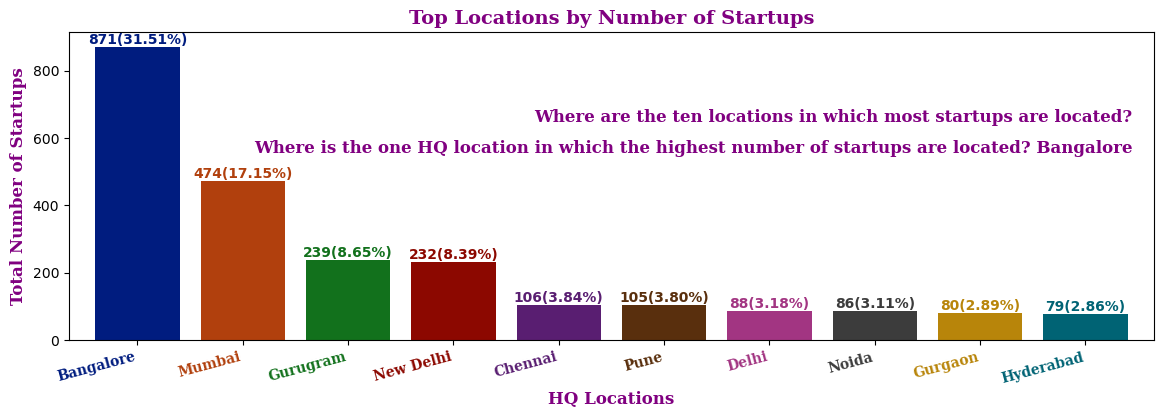

In [35]:
df_filtered = df_concat[df_concat['Location'] != 'Unknown']
location_startup = df_filtered.groupby('Location')['Company Brand'].count()
sorted_locations = location_startup.sort_values(ascending=False)  # Sort the locations by the count of startups in descending order
top_startup_locations = sorted_locations.head(10)  # Select the top 10 locations

bar_colors = sns.color_palette('dark', n_colors=len(top_startup_locations))  # Choose bar colors using the color palette
plt.figure(figsize=(14, 4)) # Plot bar chart
ax = top_startup_locations.plot(kind='bar', color=bar_colors, width=0.8)

for p, location, count, color in zip(ax.patches, top_startup_locations.index, top_startup_locations.values, bar_colors):
    percentage = (count / location_startup.sum()) * 100
    wrapped_text = '\n'.join(textwrap.wrap(location, width=12))
    annotation_text = f'{count}({percentage:.2f}%)'
    ax.annotate(annotation_text,
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color=color, fontweight='bold',
                xytext=(0, 5), textcoords='offset points')

for label, color in zip(ax.get_xticklabels(), bar_colors):
    label.set_color(color)
ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha='right', fontsize=10, fontweight='bold', family='serif')
plt.text(0.98, 0.75, 'Where are the ten locations in which most startups are located?', transform=ax.transAxes,
         fontsize=12, color='purple', ha='right', va='top', fontweight='bold', family='serif')
plt.text(0.98, 0.65, f'Where is the one HQ location in which the highest number of startups are located? {top_startup_locations.idxmax()}', transform=ax.transAxes,
         fontsize=12, color='purple', ha='right', va='top', fontweight='bold', family='serif')

# Set graph title and labels
plt.title('Top Locations by Number of Startups', fontsize=14, fontweight='bold', color='purple', family='serif')
plt.xlabel('HQ Locations', fontsize=12, color='purple', fontweight='bold', family='serif')
plt.ylabel('Total Number of Startups', fontsize=12, color='purple', fontweight='bold', family='serif')

plt.show()


## 4) Which sectors have the highest number of startups?

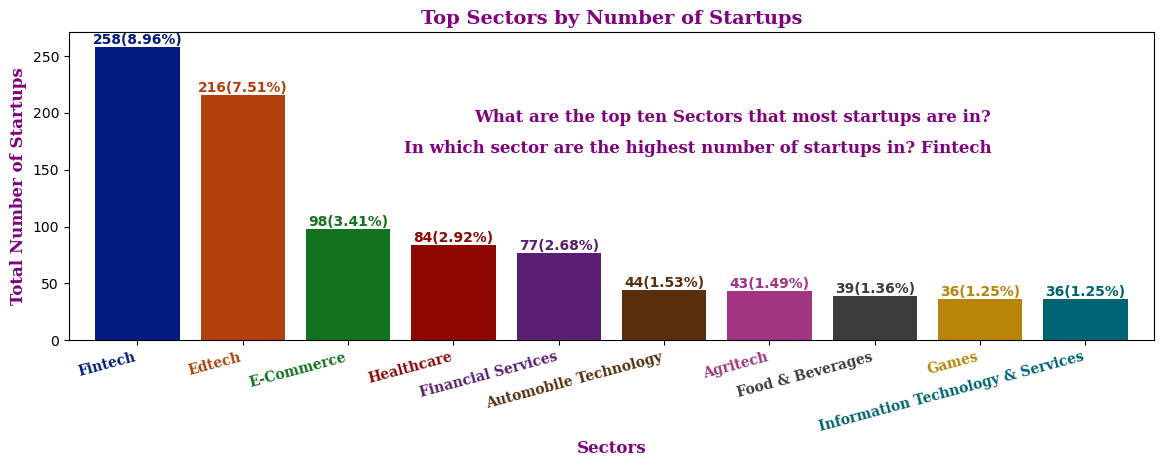

In [32]:
sector_startup = df_concat.groupby('Sector')['Company Brand'].count()
sorted_sectors = sector_startup.sort_values(ascending=False)# Sort the sectors by the count of startups in descending order
top_startup_sectors = sorted_sectors.head(10) # Select the top 10 sectors
bar_colors = sns.color_palette('dark', n_colors=len(top_startup_sectors))# Choose bar colors using the color palette
plt.figure(figsize=(14, 4))# Plot the bar chart
ax = top_startup_sectors.plot(kind='bar', color=bar_colors, width=0.8)
for p, sector, count, color in zip(ax.patches, top_startup_sectors.index, top_startup_sectors.values, bar_colors):
 
    percentage = (count / sector_startup.sum()) * 100
    wrapped_text = '\n'.join(textwrap.wrap(sector, width=12))
    annotation_text = f'{count}({percentage:.2f}%)'    
    ax.annotate(annotation_text,
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color=color, fontweight='bold',
                xytext=(0, 5), textcoords='offset points')
for label, color in zip(ax.get_xticklabels(), bar_colors):# Set the color of the corresponding x-axis label to match the bar color
    label.set_color(color)
ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha='right', fontsize=10, fontweight='bold', family='serif')
plt.text(0.85, 0.75, 'What are the top ten Sectors that most startups are in?', transform=ax.transAxes, # Add text on the graph
         fontsize=12, color='purple', ha='right', va='top', fontweight='bold', family='serif')
plt.text(0.85, 0.65, f'In which sector are the highest number of startups in? {top_startup_sectors.idxmax()}', transform=ax.transAxes,
         fontsize=12, color='purple', ha='right', va='top', fontweight='bold', family='serif')
plt.title('Top Sectors by Number of Startups', fontsize=14, fontweight='bold', color='purple', family='serif')# Set graph title and labels
plt.xlabel('Sectors', fontsize=12, color='purple', fontweight='bold', family='serif')
plt.ylabel('Total Number of Startups', fontsize=12, color='purple', fontweight='bold', family='serif')
plt.show()

## 5) Does the stage of a start-up affect the amount of funding a start-up received?

In [33]:
# Perform the Kruskal-Wallis test to assess if there are significant differences in funding across stages
statistic, p_value = kruskal(*[group['Amount'] for name, group in df_concat.groupby('Stage')])
print(f'Kruskal-Wallis Statistic: {statistic}')
print(f'P-value: {p_value}')
alpha = 0.05

# Interpret the results
print()
if p_value < alpha:
    print('P-value is less than 0.05, meaning the Kruskal-Wallis test rejects the null hypothesis. There are significant differences in funding across stages.')
else:
    print('The Kruskal-Wallis test fails to reject the null hypothesis. There are no significant differences in funding across stages.')

Kruskal-Wallis Statistic: 1051.511707490489
P-value: 1.0475328069998773e-181

P-value is less than 0.05, meaning the Kruskal-Wallis test rejects the null hypothesis. There are significant differences in funding across stages.


## 6) Which Stages are highly funded?

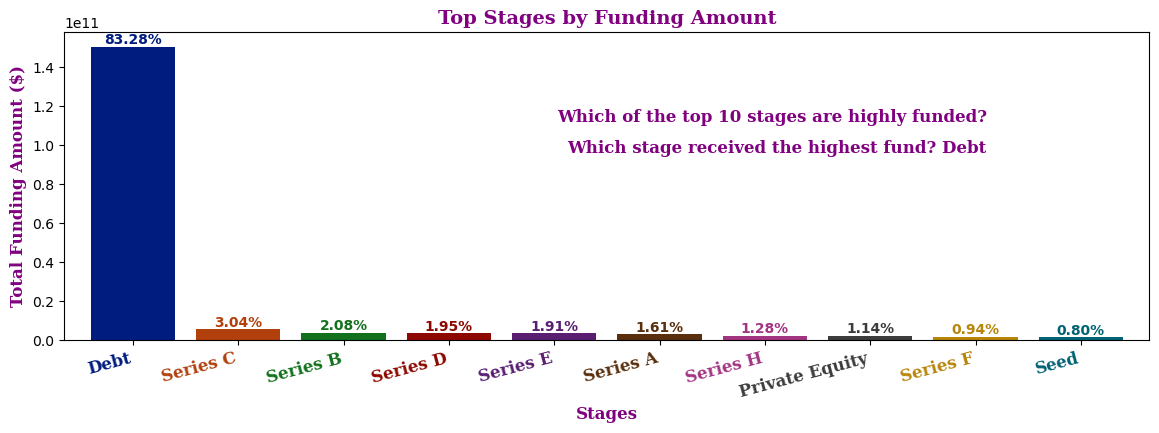

In [34]:
df_filtered = df_concat[df_concat['Stage'] != 'Unknown']  # Filter out rows with 'Unknown' in the 'Stage' column
stage_startup = df_filtered.groupby('Stage')['Amount'].sum()  # Group by 'Stage' and sum the funding amounts
sorted_stages = stage_startup.sort_values(ascending=False)  # Sort stages by the sum of funding amounts
top_startup_stages = sorted_stages.head(10)  # Select the top 10 stages

bar_colors = sns.color_palette('dark', n_colors=len(top_startup_stages)) # Choose bar colors using the color palette
plt.figure(figsize=(14, 4)) # Plot the bar chart
ax = top_startup_stages.plot(kind='bar', color=bar_colors, width=0.8)
for p, stage, amount, color in zip(ax.patches, top_startup_stages.index, top_startup_stages.values, bar_colors):
    percentage = (amount / stage_startup.sum()) * 100 # Add annotations to the bars
    wrapped_text = '\n'.join(textwrap.wrap(stage, width=12))
    annotation_text = f'{percentage:.2f}%'
    ax.annotate(annotation_text,
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color=color, fontweight='bold',
                xytext=(0, 5), textcoords='offset points')

for label, color in zip(ax.get_xticklabels(), bar_colors): # Set colors for x-axis labels
    label.set_color(color)
ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha='right', fontsize=12, fontweight='bold', family='serif')
plt.text(0.85, 0.75, 'Which of the top 10 stages are highly funded?', transform=ax.transAxes, # Add text on the graph
         fontsize=12, color='purple', ha='right', va='top', fontweight='bold', family='serif')
plt.text(0.85, 0.65, f'Which stage received the highest fund? {top_startup_stages.idxmax()}', transform=ax.transAxes,
         fontsize=12, color='purple', ha='right', va='top', fontweight='bold', family='serif')

plt.title('Top Stages by Funding Amount', fontsize=14, fontweight='bold', color='purple', family='serif')
plt.xlabel('Stages', fontsize=12, color='purple', fontweight='bold', family='serif')
plt.ylabel('Total Funding Amount ($)', fontsize=12, color='purple', fontweight='bold', family='serif')
plt.show()